# K-Means and DBSCAN clustering on LTRM Random Forest Interpolated Data

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans,DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors

### Load and filter data

In [2]:
df = pd.read_csv('..\LTRM data\RF interpolation\water_full.csv')
df.drop(["SHEETBAR","DATE","LATITUDE","LONGITUDE","FLDNUM","STRATUM","LOCATCD",
         "SECCHI","TURB","YEAR","SEASON"],axis=1,inplace=True)
print(df.shape)
df.describe()

(76669, 9)


,TN,TP,TEMP,DO,COND,VEL,SS,WDP,CHLcal
count,76669.000000,76669.000000,76669.000000,76669.000000,76669.000000,76669.000000,76669.000000,76669.000000,76669.000000
mean,2.790170,0.200746,14.876312,10.030313,488.608297,0.344754,51.612127,3.356567,26.360633
std,1.597177,0.152338,9.430287,3.204959,146.626410,0.406437,84.641490,3.191891,30.122340
min,0.024000,0.002000,0.000000,0.000000,0.000000,0.000000,0.020000,0.010000,0.018300
25%,1.910000,0.113000,9.300000,7.900000,398.000000,0.030000,10.030000,0.960000,8.032110
50%,2.611000,0.163000,14.700000,9.700000,460.000000,0.200000,25.200000,2.270000,16.944640
75%,3.374000,0.248000,23.800000,12.200000,559.000000,0.550000,57.300000,4.830000,33.468400
max,187.429000,6.443000,40.300000,29.900000,2149.000000,6.000000,2485.000000,40.200000,745.741850


### Scale data using robust scaler

This step makes it so units of each variable are irrelevant when clustering. We use robust scaling because it is more robust agaisnt outliers, which we have.

In [3]:
cols = df.columns
df_scaled = RobustScaler().fit_transform(df)
df_scaled = pd.DataFrame(df_scaled,columns=cols)
df_scaled.describe()

,TN,TP,TEMP,DO,COND,VEL,SS,WDP,CHLcal
count,76669.000000,76669.000000,76669.000000,76669.000000,76669.000000,76669.000000,76669.000000,76669.000000,76669.000000
mean,0.122384,0.279600,0.012159,0.076817,0.177691,0.278374,0.558750,0.280767,0.370180
std,1.090968,1.128430,0.650365,0.745339,0.910723,0.781609,1.790596,0.824778,1.184227
min,-1.767077,-1.192593,-1.013793,-2.255814,-2.857143,-0.384615,-0.532685,-0.583979,-0.665441
25%,-0.478825,-0.370370,-0.372414,-0.418605,-0.385093,-0.326923,-0.320922,-0.338501,-0.350386
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.521175,0.629630,0.627586,0.581395,0.614907,0.673077,0.679078,0.661499,0.649614
max,126.241803,46.518519,1.765517,4.697674,10.490683,11.153846,52.037233,9.801034,28.651867


### K-means

First we need to find the optimal value of k.

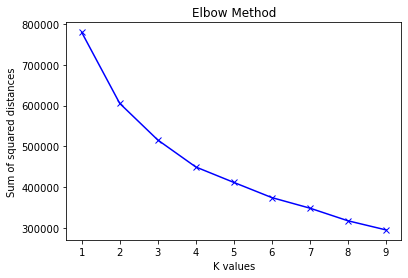

In [4]:
# Arbitrarily selecting a range of values for K
K = range(1,10)
sum_of_squared_distances = []
# Using Scikit Learn’s KMeans Algorithm to find sum of squared distances
for k in K:
    model = KMeans(n_clusters=k).fit(df_scaled)
    sum_of_squared_distances.append(model.inertia_)
plt.plot(K, sum_of_squared_distances, "bx-")
plt.xlabel("K values")
plt.ylabel("Sum of squared distances")
plt.title("Elbow Method")
plt.show()

It seems like the optimal value of K is between 2 and 5. We will use the Silhouette coefficient to tell, and the K with the highest silhouette coefficient is the optimal k.

In [5]:
for k in [2,3,4,5]:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    labels = kmeans.predict(df_scaled)
    centroids = kmeans.cluster_centers_
    s = metrics.silhouette_score(df_scaled, labels, metric='euclidean')
    print(f"k={k}, s = {s:.2f}")

k=2, s = 0.46
k=3, s = 0.28
k=4, s = 0.27
k=5, s = 0.29


The optimal value of k is 2, so this analysis reveals 2 global states!

In [11]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_scaled)
labels = kmeans.predict(df_scaled)
centroids = kmeans.cluster_centers_

In [14]:
pd.DataFrame(centroids,columns=cols)

,TN,TP,TEMP,DO,COND,VEL,SS,WDP,CHLcal
0,0.071918,0.115245,-0.014912,0.131685,0.164938,0.146180,0.103755,0.159047,0.383770
1,0.542964,1.649320,0.237772,-0.380451,0.283979,1.380071,4.350651,1.295170,0.256918


In [16]:
np.unique(labels,return_counts=True)

(array([0, 1]), array([68426,  8243], dtype=int64))

In [18]:
print(f"Percentage of points in 1st cluster: {68426/len(labels):.4f}")
print(f"Percentage of points in 2nd cluster: {8243/len(labels):.4f}")

Percentage of points in 1st cluster: 0.8925
Percentage of points in 2nd cluster: 0.1075


### DB Scan

This clustering requires 2 parameters, min_samples and epsilon. To determine epsilon, we will use the previously discussed knee method.

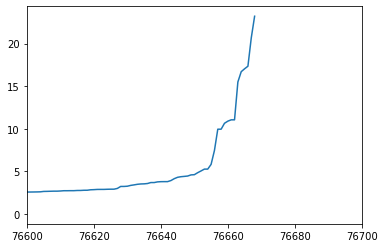

In [19]:
nearest_neighbors = NearestNeighbors(n_neighbors=5)
nearest_neighbors.fit(df_scaled)
distances, indices = nearest_neighbors.kneighbors(df_scaled)
distances = np.sort(distances, axis=0)[:, 1]
plt.plot(distances)
plt.xlim(76600,76700)
plt.show()

This analysis reveals that epsilon should be 5

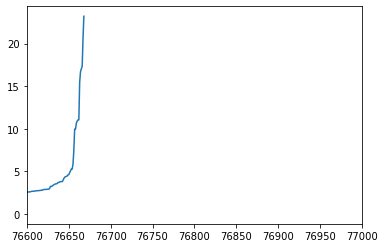

In [20]:
nearest_neighbors = NearestNeighbors(n_neighbors=2)
nearest_neighbors.fit(df_scaled)
distances, indices = nearest_neighbors.kneighbors(df_scaled)
distances = np.sort(distances, axis=0)[:, 1]
plt.plot(distances)
plt.xlim(76600,77000)
plt.show()

This analysis also reveals that epsilon should be 5. So epsilon will be 5. It's also a general rule that min_samples should be greater than or equal to the dimentionality of the dataset, so 10 seems like a good value for this parameter.

In [21]:
dbscan = DBSCAN(eps=5, min_samples=10)
dbscan.fit(df_scaled)

labels = dbscan.labels_

# Creating a numpy array with all values set to false by default
core_samples_mask = np.zeros_like(labels, dtype=bool)
# Setting core and border points (all points that are not -1) to True
core_samples_mask[dbscan.core_sample_indices_] = True
# Finding the number of clusters in labels (ignoring noise if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
# Printing the number of clusters and number of noise points (outliers)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# Evaluating the quality of clusters
s = metrics.silhouette_score(X, dbscan.labels_)
print(f"Silhouette Coefficient: {s:.2f}")

MemoryError: 